In [377]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from utils import *
from sklearn.preprocessing import StandardScaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Field Definitions
- step: is a timestep, each timestep is 0.25 seconds
- spool: is the integral of material feedrate from the beginning of the production. This is proportional to the mass of the total fiber extruded.
- diameter: is in 10e-5 meter
- speed: is mapped between 0 and 100
- motorV: is the PWM dutycycle of the motor and it's mapped between 0 and 100
- extfrq: is the frequency of the feeding extruder, which corresponds to the feedrate of the material
- temp: is the temperture of the heating chamber
- rests of the columns can be ignored for now

- Explore = Train Data; Exploit = Test Data

### Only uncomment and re-run the below code to change the base processed data

In [393]:
filenames = {
    'explore0':'2019_08_20_14_38.txt',
    'explore1':'2019_09_09_09_54.txt',
    'exploit0':'2019_08_20_15_36.txt',
    'exploit1':'2019_08_20_16_31.txt',
    'exploit2':'2019_08_20_17_06.txt', 
    'exploit3':'2019_08_21_13_04.txt',
    'exploit4':'2019_08_21_13_44.txt',
    'exploit5':'2019_08_21_16_19.txt'
}
columns = ['step', 'spool', 'diameter', 'speed', 'motorV', 'extfrq', 'target', 'greedy_m', 'greedy_e', 
           'reward', 'Q_exam', 'am_exam', 'a_exam', 'unk', 'temp']

# Create dict of dataframes
data = {}
for key in filenames:
    df = pd.read_csv('data/'+filenames[key], header=0, names=columns)
    df.reset_index(inplace=True, drop=True)
    df = df.drop(['unk', 'Q_exam', 'am_exam', 'a_exam', 'greedy_m', 'greedy_e', 'reward', 'step'], axis=1)
    for col in df.columns:
        df[col] = df[col].str.split(':').apply(lambda x: x[1])
    df = df.apply(pd.to_numeric)
    # Split dfs where 'spool' resets to zero
    last_split = 0
    split_idx = df[df.spool == 0].index.tolist()
    split_idx.append(-1)
    for n,i in enumerate(split_idx):
        df_run = df[last_split:i]
        if len(df_run) > 0:
            df_run = df_run.reset_index(drop=True)
            df_run.index.name = 'step'
            data[key+'_'+str(n)] = df_run
        last_split = i
        
data_keys = list(data.keys())
print('# of keys in data: ', len(data_keys))
print(data_keys)

# of keys in data:  15
['explore0_1', 'explore0_2', 'explore0_3', 'explore0_4', 'explore1_1', 'explore1_2', 'explore1_3', 'explore1_4', 'explore1_5', 'exploit0_1', 'exploit1_1', 'exploit2_1', 'exploit3_1', 'exploit4_1', 'exploit5_1']


In [399]:
with open('data_processed/data_dict.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

## How to import processed data into a new file/notebook:
Run the code in the cell below:

In [400]:
with open('data_processed/data_dict.pickle', 'rb') as handle:
    data = pickle.load(handle)
data_keys = list(data.keys())

In [413]:
# Write clean data back out to csv files for matlab use

for k in data_keys:
    timestamp = filenames[k[:-2]][:-4]
    fname = 'matlab_data/'+k+'_'+timestamp+'.csv'
    data[k].to_csv(fname)

And access a given dataframe, representing a single run (starting always with spool == 0) as follows:

In [396]:
df = data[data_keys[1]]
df.head()

,spool,diameter,speed,motorV,extfrq,target,temp
step,,,,,,,
0,0.00,32.3,76.00,25.25,19.16,50.6,80.105
1,0.02,31.4,75.76,26.08,20.01,50.6,79.968
2,0.03,32.9,71.92,28.07,21.86,50.6,80.036
3,0.05,35.1,58.96,31.17,24.79,50.6,80.139
4,0.06,35.2,49.04,35.25,28.85,50.6,80.036


In [402]:
df.columns

Index(['spool', 'diameter', 'speed', 'motorV', 'extfrq', 'target', 'temp'], dtype='object')

Length of each dataset in the data dictionary:

In [397]:
total = 0
for x in data_keys:
    print(x, len(data[x]))
    total += len(data[x])
print('total samples: ', total)

explore0_1 2693
explore0_2 2424
explore0_3 2530
explore0_4 2880
explore1_1 8890
explore1_2 8919
explore1_3 7789
explore1_4 7919
explore1_5 8143
exploit0_1 2530
exploit1_1 2826
exploit2_1 2735
exploit3_1 2484
exploit4_1 2597
exploit5_1 2582
total samples:  67941


### Feature Generation
a) Model D3 using v2 and v3 but use motor V for V3  
b) 1/sqrt(w)  
c) 1/sqrt(w^2)  

In [319]:
for x in data_keys:
    df = data[x]
    df['d3'] = np.sqrt(df.extfrq/df.speed)
    df['inv_sqrt_w'] = 1/np.sqrt(df.speed)
    df['inv_sqrt_w2'] = 1/np.sqrt(df.speed**2)
    data[x] = df
    

In [320]:
df = data[data_keys[2]]
df.head()

,spool,diameter,speed,motorV,extfrq,target,temp,d3,inv_sqrt_w,inv_sqrt_w2
0,0.00,28.8,77.44,23.97,19.13,51.2,79.899,0.497021,0.113636,0.012913
1,0.02,28.5,77.28,24.79,19.92,51.2,79.899,0.507705,0.113754,0.012940
2,0.03,28.7,73.76,26.85,21.66,51.2,79.933,0.541900,0.116437,0.013557
3,0.05,28.4,61.04,29.76,24.54,51.2,79.933,0.634060,0.127995,0.016383
4,0.06,28.9,50.64,33.33,28.15,51.2,79.899,0.745577,0.140525,0.019747


### Data Cleaning
1. Remove first 100 samples for each run. MotorV and speed have a strange, nonlinear relationship when the run initializes, probably due to a lack of consistent load on the motor as the fiber is started.

Text(0, 0.5, 'motorV')

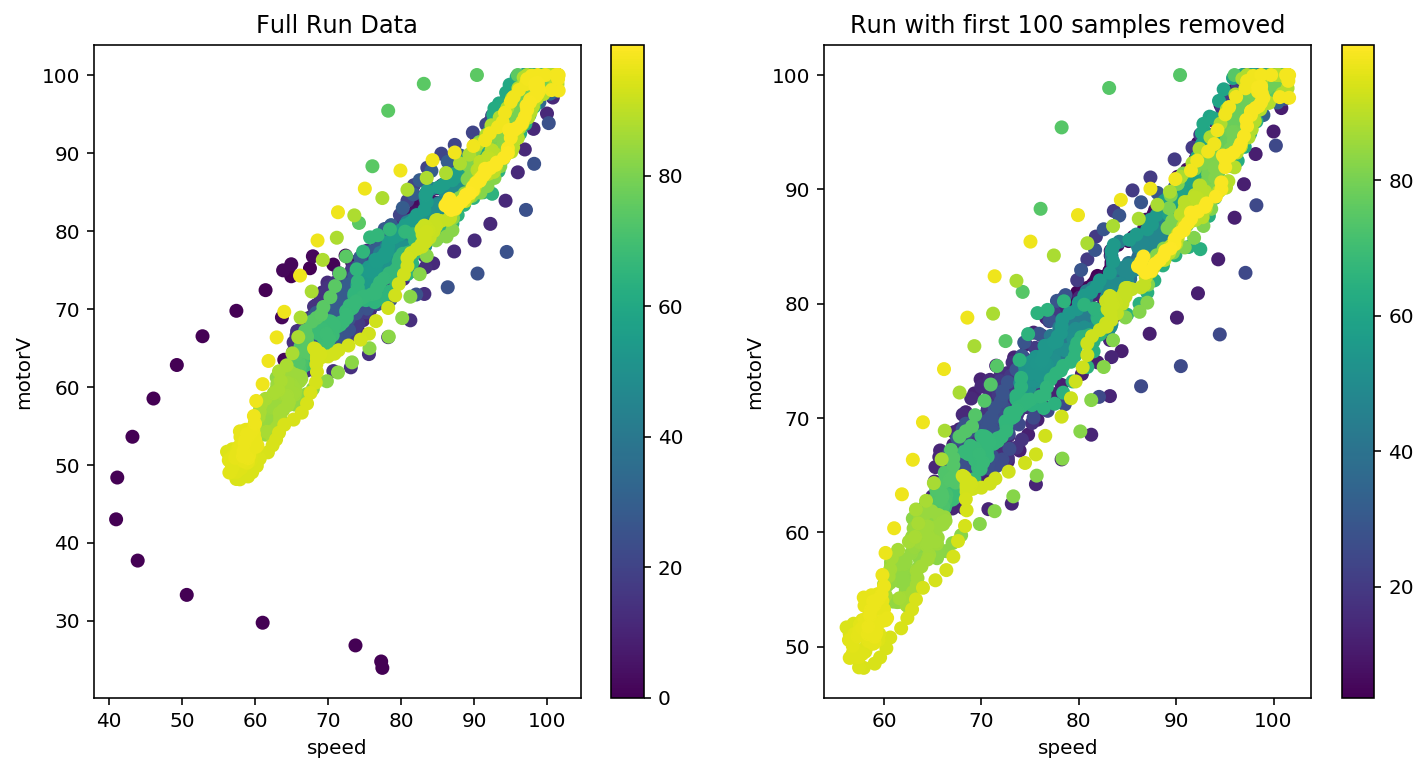

In [360]:
### SELECT ANY RUN INDEX:
df = data[data_keys[2]]

fig, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize=(12,6))

im1 = ax1.scatter(df.speed, df.motorV, c=df.spool)
ax1.set_title('Full Run Data')
fig.colorbar(im1, ax=ax1)
ax1.set_xlabel('speed')
ax1.set_ylabel('motorV')

im2 = ax2.scatter(df.speed[100:], df.motorV[100:], c=df.spool[100:])
ax2.set_title('Run with first 100 samples removed')
fig.colorbar(im2, ax=ax2)
ax2.set_xlabel('speed')
ax2.set_ylabel('motorV')

In [361]:
for x in data_keys:
    data[x] = data[x][100:]

2. Nearly 7000 rows have motorV of zero. So maybe we should just use speed instead??
    - Swapped speed (never zero) in for motorV in denominator of feature D3

## Basic Stats for Processed Raw Data

In [362]:
all_stacked = pd.concat([data[k] for k in data_keys]).reset_index().rename(columns={'index':'step'})

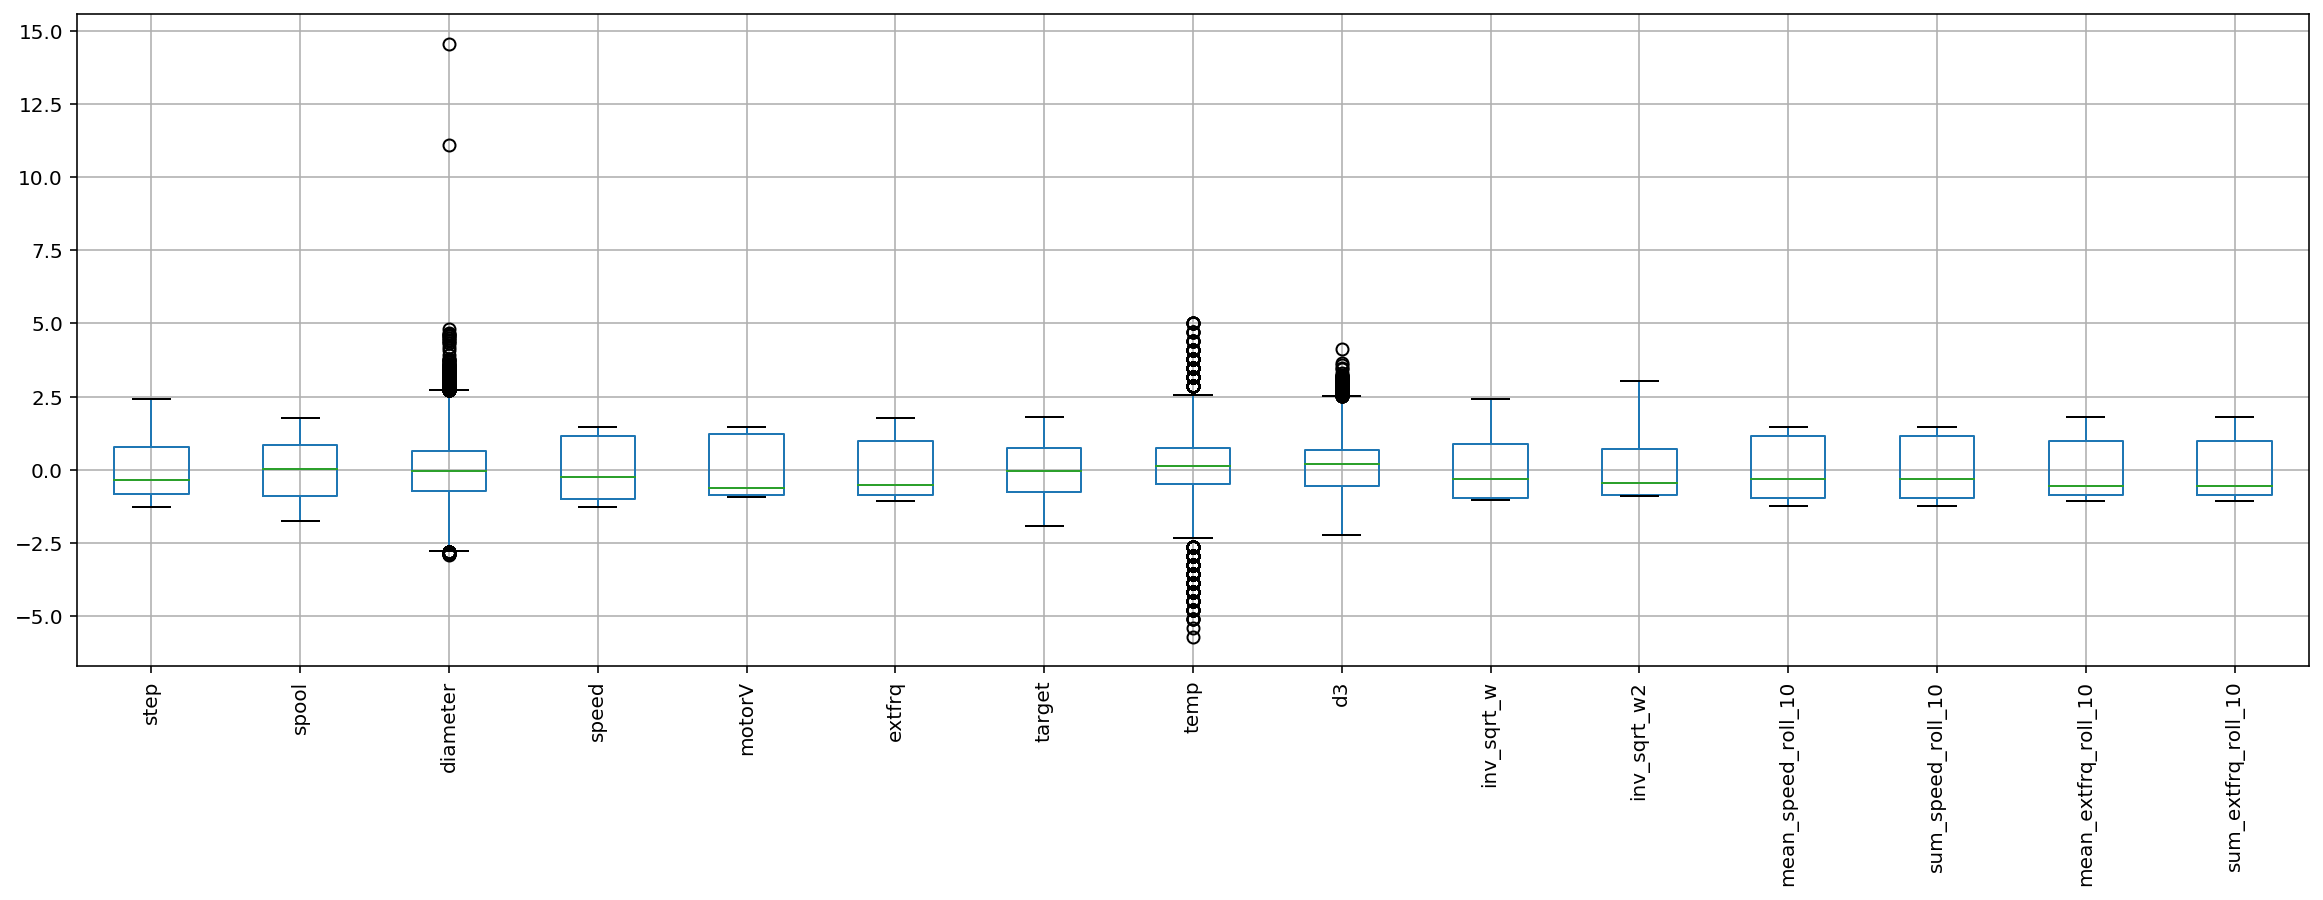

In [363]:
cols = all_stacked.columns
# Z-Score
for col in cols:
    all_stacked[col] = (all_stacked[col] - all_stacked[col].mean())/all_stacked[col].std(ddof=0)

all_stacked.boxplot(figsize=(20,6), rot=90)

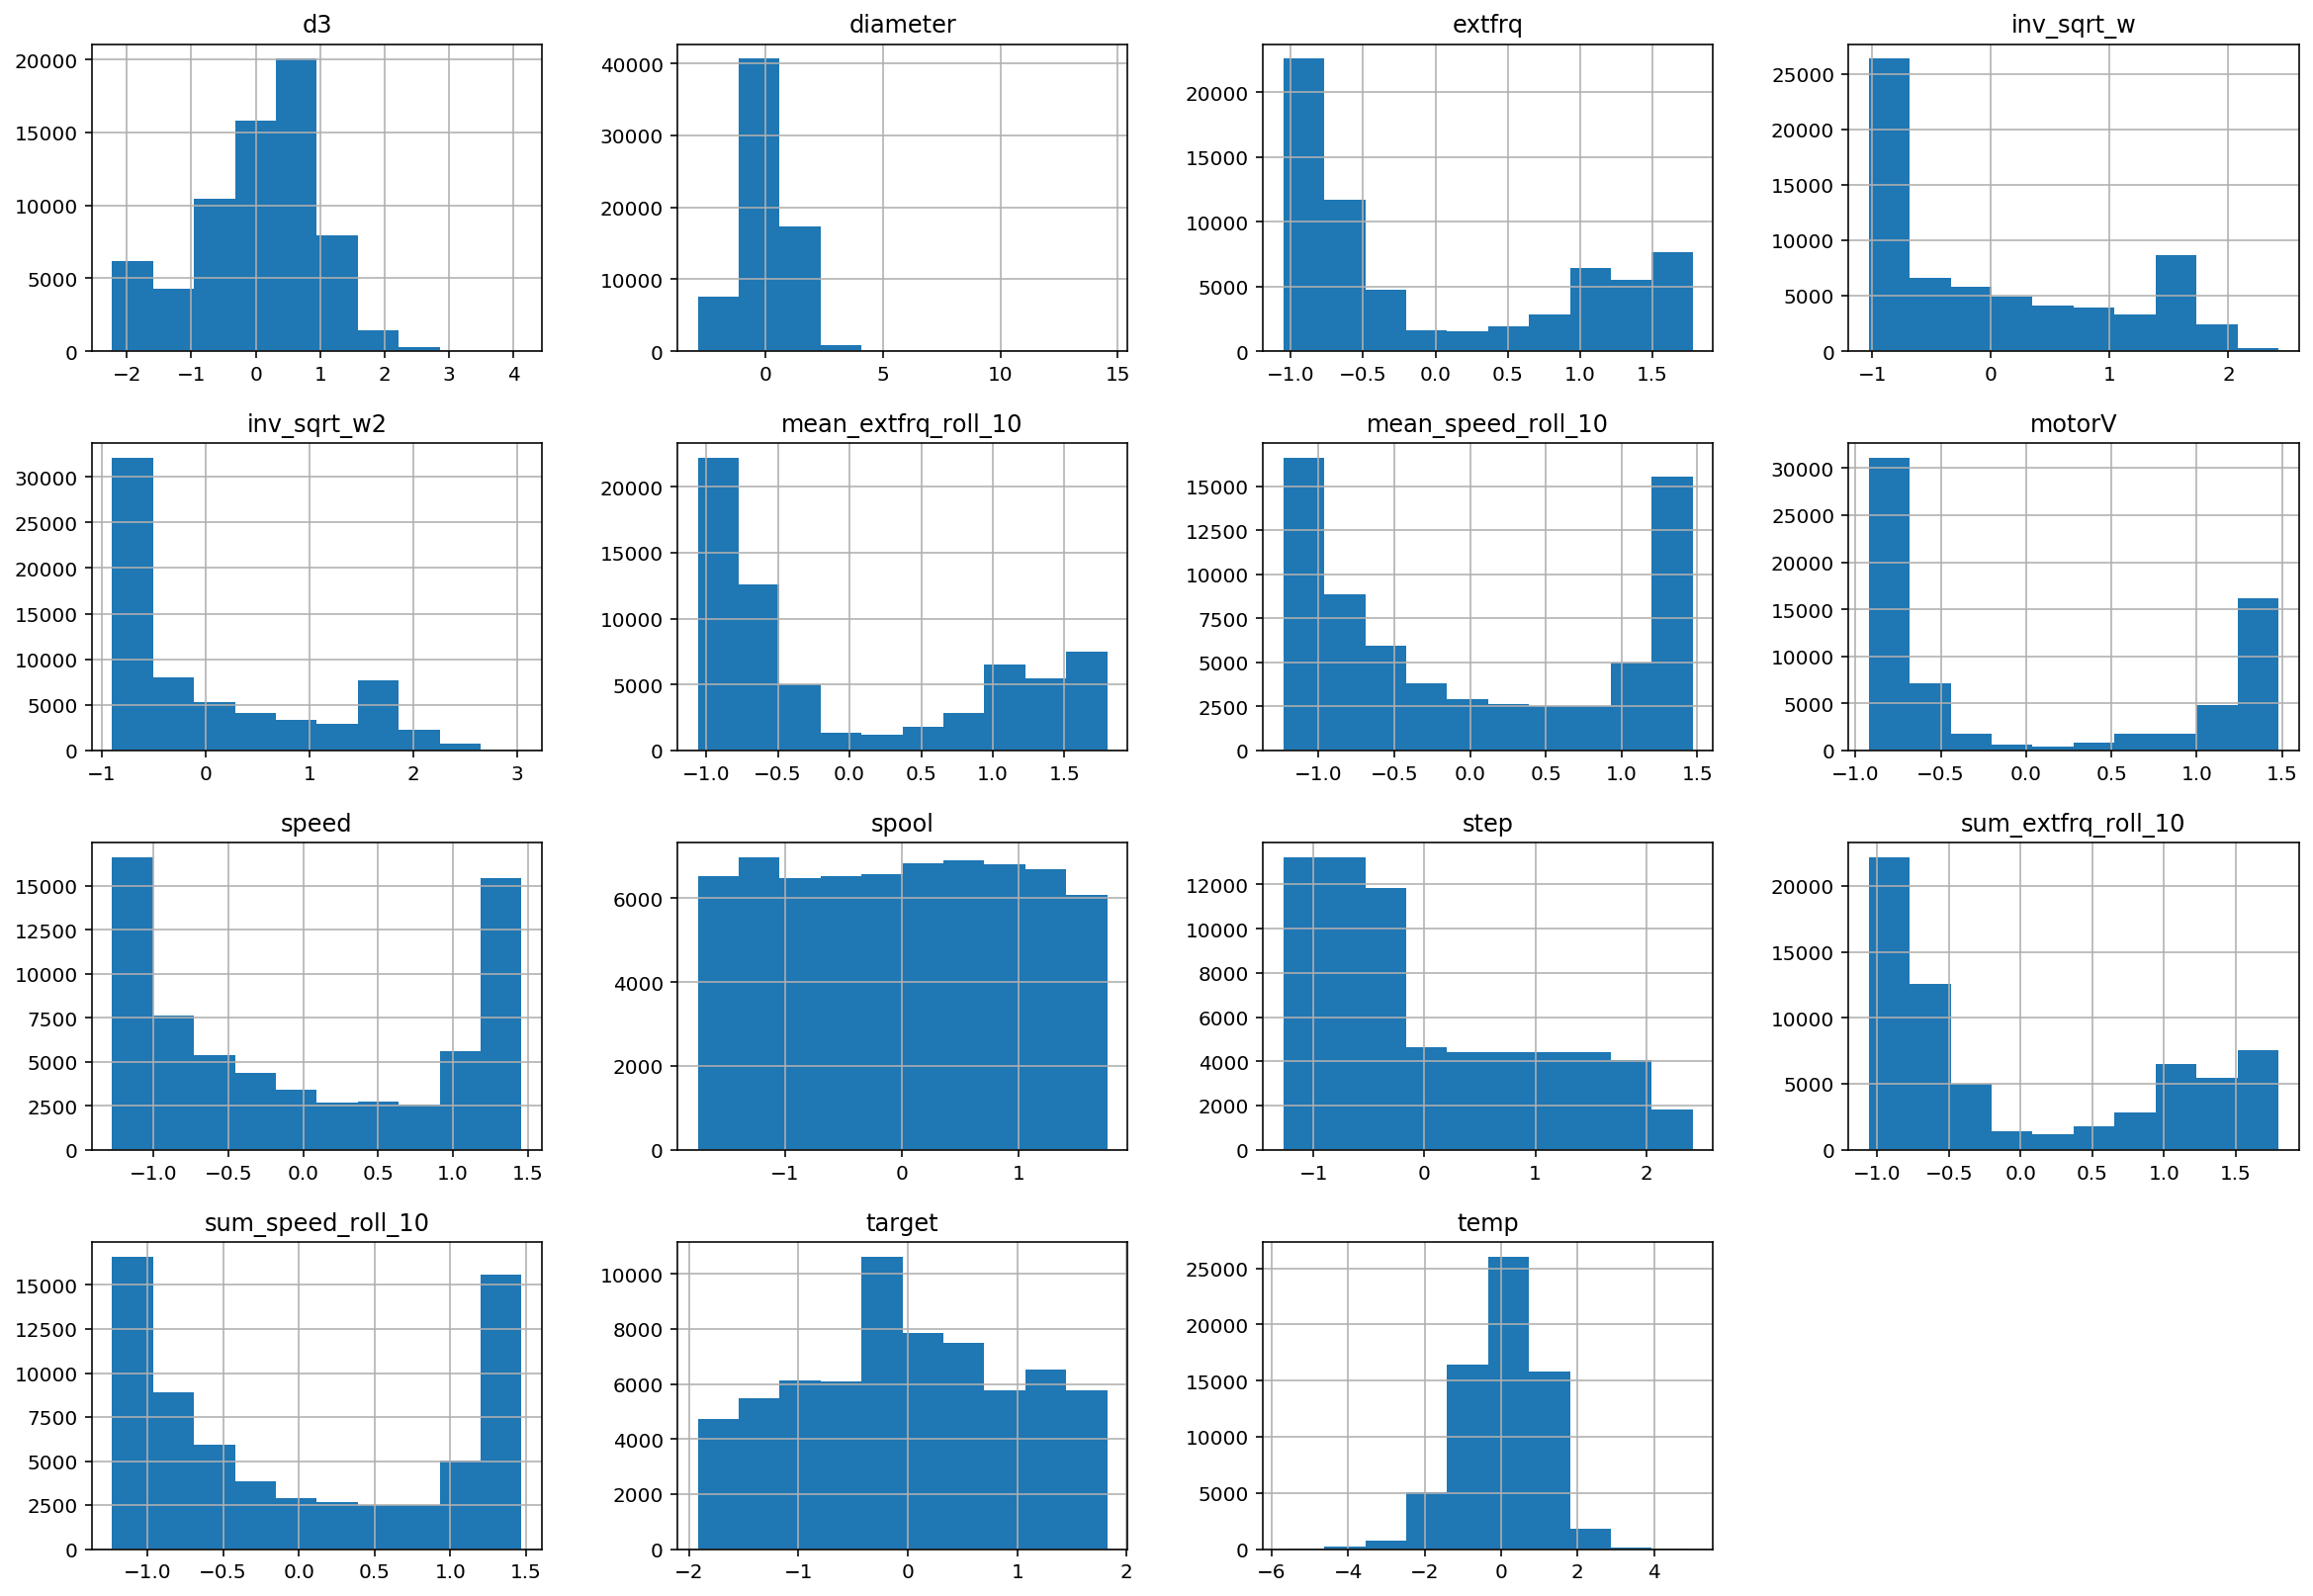

In [364]:
hist = all_stacked.hist(figsize=(20,14))

[Text(0.5, 0, 'step'),
 Text(1.5, 0, 'spool'),
 Text(2.5, 0, 'diameter'),
 Text(3.5, 0, 'speed'),
 Text(4.5, 0, 'motorV'),
 Text(5.5, 0, 'extfrq'),
 Text(6.5, 0, 'temp'),
 Text(7.5, 0, 'd3'),
 Text(8.5, 0, 'inv_sqrt_w'),
 Text(9.5, 0, 'inv_sqrt_w2'),
 Text(10.5, 0, 'mean_speed_roll_10'),
 Text(11.5, 0, 'sum_speed_roll_10'),
 Text(12.5, 0, 'mean_extfrq_roll_10'),
 Text(13.5, 0, 'sum_extfrq_roll_10')]

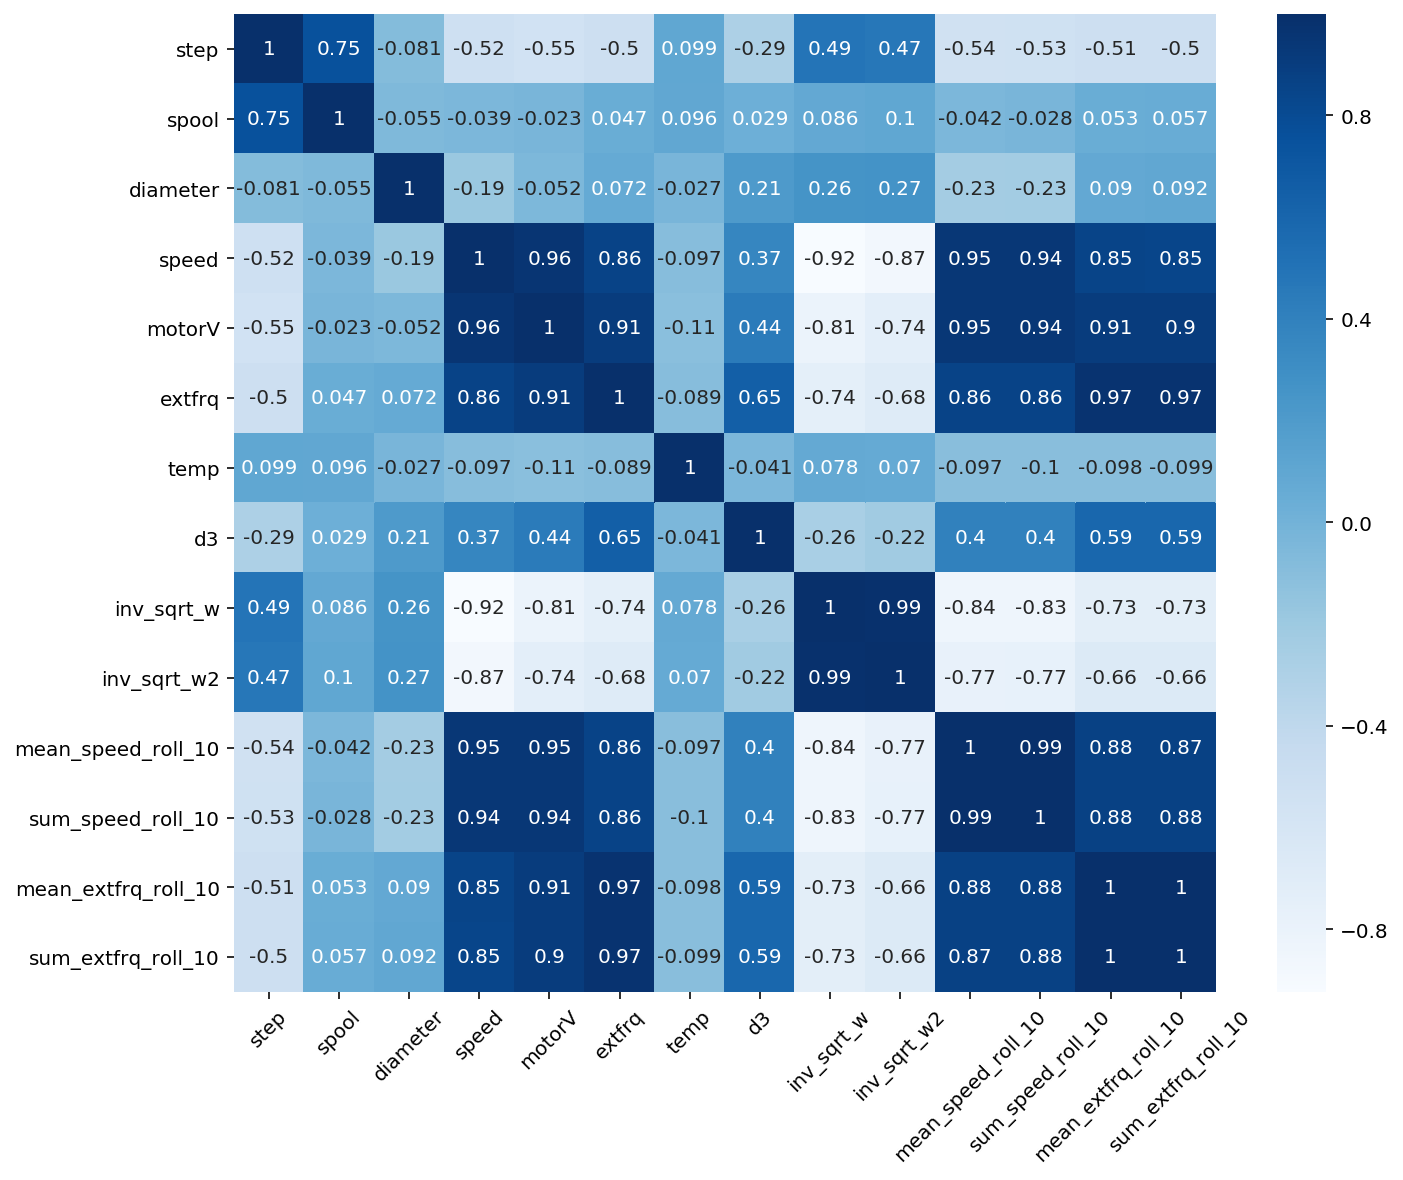

In [365]:
# Correlation Plot
f, ax = plt.subplots(figsize=(11, 9))
cor = train_all.corr()
ax = sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

## Feature Analysis

Cross Correlation

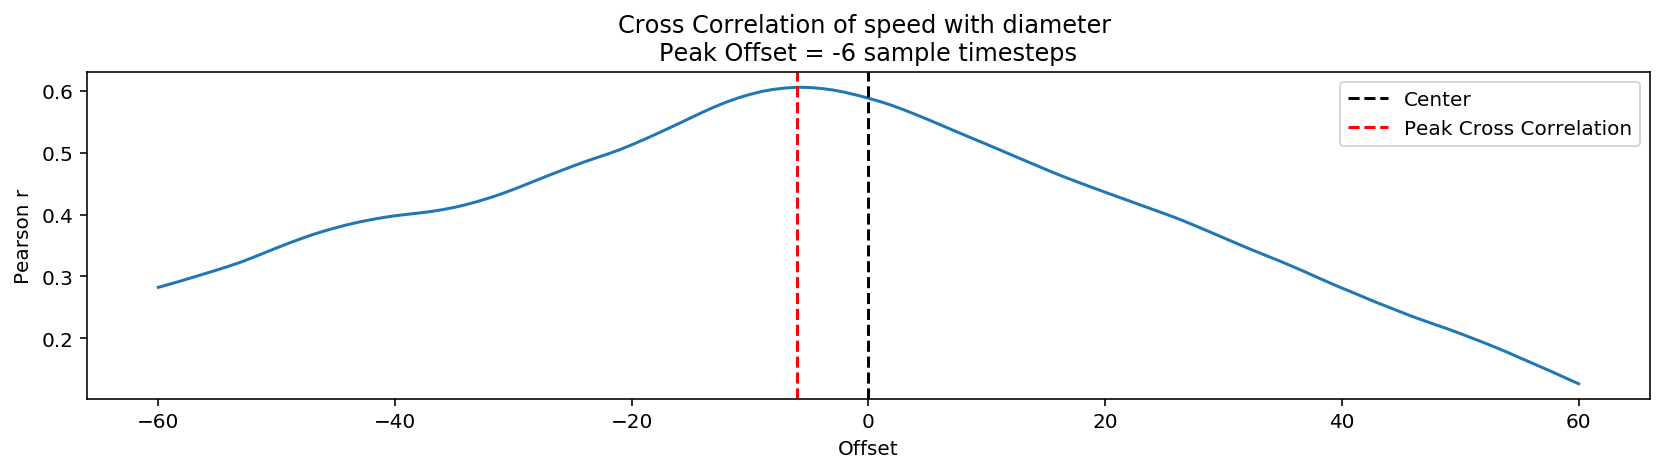

In [366]:
### Angular speed and diameter
df = data[data_keys[1]]

d1 = df['speed']
d2 = df['diameter']
seconds = 15
fps = 4

lags = list(range(-int(seconds*fps), int(seconds*fps+1)))
rs = [abs(crosscorr(d1,d2,lag)) for lag in lags]
peak_offset = lags[np.argmax(rs)]

f,ax=plt.subplots(figsize=(14,3))
ax.plot(lags, rs)
ax.axvline(0,color='k',linestyle='--',label='Center')
ax.axvline(peak_offset,color='r',linestyle='--',label='Peak Cross Correlation')
ax.set(title=f'Cross Correlation of {d1.name} with {d2.name} \nPeak Offset = {peak_offset} sample timesteps', xlabel='Offset',ylabel='Pearson r')
plt.legend()


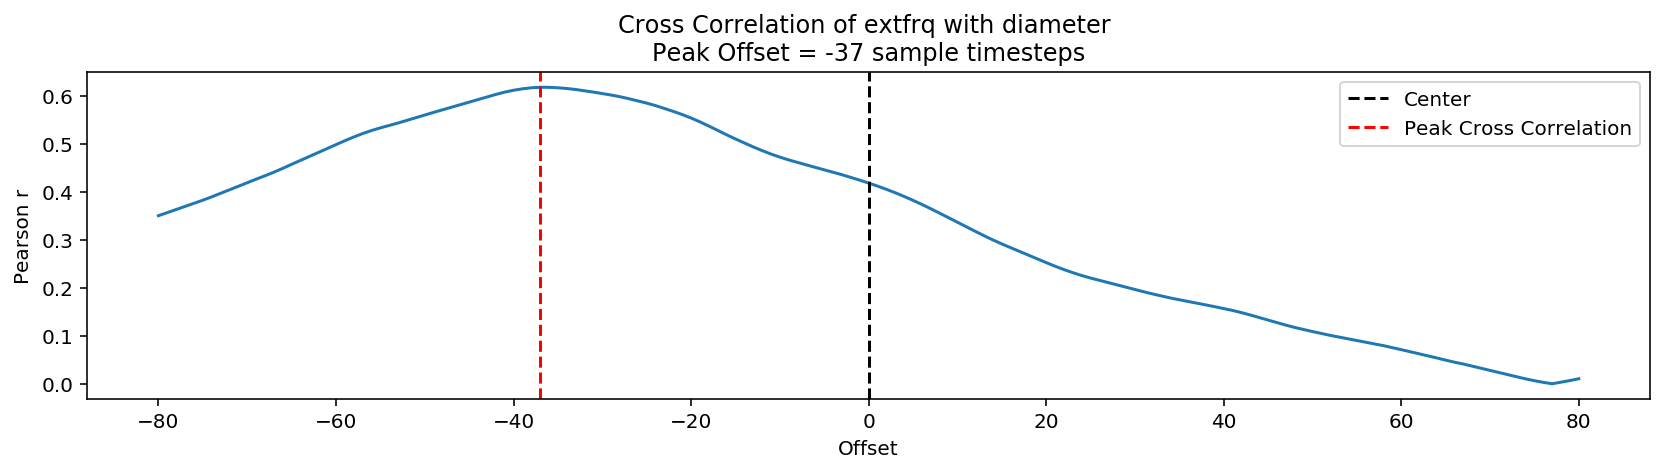

In [367]:
### Extruder Freq and Diameter
d1 = df['extfrq']
d2 = df['diameter']
seconds = 20
fps = 4

lags = list(range(-int(seconds*fps), int(seconds*fps+1)))
rs = [abs(crosscorr(d1,d2,lag)) for lag in lags]
peak_offset = lags[np.argmax(rs)]

f,ax=plt.subplots(figsize=(14,3))
ax.plot(lags, rs)
ax.axvline(0,color='k',linestyle='--',label='Center')
ax.axvline(peak_offset,color='r',linestyle='--',label='Peak Cross Correlation')
ax.set(title=f'Cross Correlation of {d1.name} with {d2.name} \nPeak Offset = {peak_offset} sample timesteps', xlabel='Offset',ylabel='Pearson r')
plt.legend()

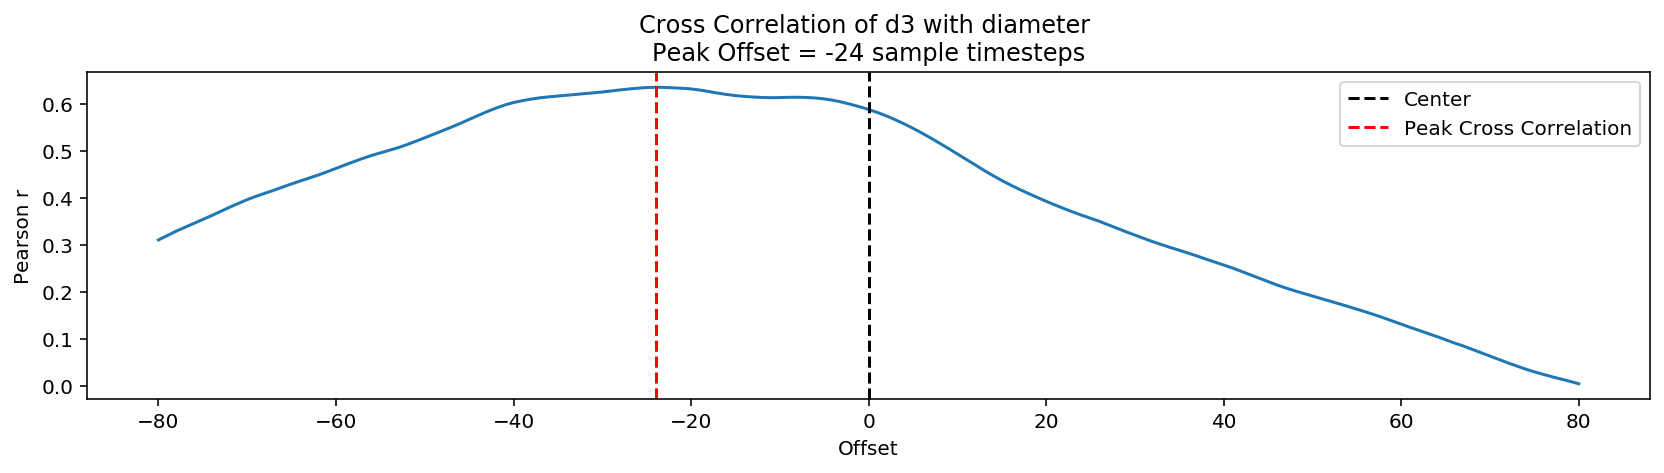

In [368]:
### Inv_sqrt_w
d1 = df['d3']
d2 = df['diameter']
seconds = 20
fps = 4

lags = list(range(-int(seconds*fps), int(seconds*fps+1)))
rs = [abs(crosscorr(d1,d2,lag)) for lag in lags]
peak_offset = lags[np.argmax(rs)]

f,ax=plt.subplots(figsize=(14,3))
ax.plot(lags, rs)
ax.axvline(0,color='k',linestyle='--',label='Center')
ax.axvline(peak_offset,color='r',linestyle='--',label='Peak Cross Correlation')
ax.set(title=f'Cross Correlation of {d1.name} with {d2.name} \nPeak Offset = {peak_offset} sample timesteps', xlabel='Offset',ylabel='Pearson r')
plt.legend()

#### Compute new features over rolling window of last 10 sec (40 timesteps)


In [372]:
for x in data_keys:
    df = data[x].copy()
    df['mean_speed_roll_10'] = df['speed'].rolling(40,min_periods=1,win_type='triang').mean()
    df['sum_speed_roll_10'] = df['speed'].rolling(40,min_periods=1,win_type='triang').sum()
    df['mean_extfrq_roll_10'] = df['extfrq'].rolling(40,min_periods=1,win_type='triang').mean()
    df['sum_extfrq_roll_10'] = df['extfrq'].rolling(40,min_periods=1,win_type='triang').sum()
    data[x] = df

In [373]:
df = data[data_keys[2]]
df.head()

,spool,diameter,speed,motorV,extfrq,target,temp,d3,inv_sqrt_w,inv_sqrt_w2,mean_speed_roll_10,sum_speed_roll_10,mean_extfrq_roll_10,sum_extfrq_roll_10
100,3.59,46.9,79.28,78.85,84.82,55.2,80.208,1.034350,0.112310,0.012614,79.280000,1.982,84.820000,2.12050
101,3.63,46.5,79.84,78.21,84.48,55.2,80.311,1.028648,0.111915,0.012525,79.420000,7.942,84.735000,8.47350
102,3.67,47.3,80.08,77.56,84.01,55.2,80.277,1.024244,0.111748,0.012488,79.555556,17.900,84.616667,19.03875
103,3.71,49.2,79.52,77.32,84.37,55.2,80.243,1.030044,0.112140,0.012575,79.620000,31.848,84.533750,33.81350
104,3.75,49.1,79.12,77.23,84.38,55.2,80.311,1.032706,0.112423,0.012639,79.619200,49.762,84.491200,52.80700


----------------

### Train - Test Split
Shoot for 80-20% split, keeping individual runs intact, and a reasonable mix from explore & exploit:

In [374]:
train_keys = ['explore0_1','explore0_3','explore0_4','explore1_1','explore1_2','explore1_4','explore1_5',
             'exploit0_1','exploit2_1','exploit4_1','exploit5_1']

test_keys = ['explore0_2','explore1_3','exploit1_1','exploit3_1']

train_all = pd.concat([data[k] for k in train_keys]).reset_index().rename(columns={'index':'step'}).drop(
    columns=['target'])
test_all = pd.concat([data[k] for k in test_keys]).reset_index().rename(columns={'index':'step'}).drop(
    columns=['target'])

X_cols = list(train_all.columns)
X_cols.remove('diameter')

In [375]:
X_train = train_all[X_cols]
X_test = test_all[X_cols]
y_train = train_all['diameter']
y_test = test_all['diameter']

In [376]:
data_feat = [X_train, y_train, X_test, y_test]

with open('data_processed/data_feat.pickle', 'wb') as handle:
    pickle.dump(data_feat, handle, protocol=pickle.HIGHEST_PROTOCOL)